In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_mydb.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_mydbtest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 2].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 2].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,8.204384,0.011638,949.166080,91963.646862,0.17128,2633.096494,20891.798384,1.0,7.0,1.549383,6.0,44.756118,1.240458e+10,36.551238
1,8.897366,0.017067,133165.511111,140629.333333,0.17128,9030.622222,31243.777778,1.0,17.0,1.546823,6.0,44.756118,1.240458e+10,36.551238
2,8.897366,0.014578,133165.511111,154464.711111,0.17128,8602.355556,34176.288889,1.0,26.0,1.557788,6.0,32.868146,1.240458e+10,37.614600
3,8.740364,0.013956,132346.311111,172942.222222,0.06938,8507.444444,32006.488889,1.0,36.0,1.531037,6.0,32.868146,1.240458e+10,37.614600
4,11.053357,0.010844,0.000000,135259.022222,0.06938,2428.933333,23826.488889,1.0,38.0,1.521409,6.0,25.194444,1.240458e+10,37.446396


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [4]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [5]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,1.799196,453.402624,1.549383,7.0
1,1.799196,453.402624,1.546823,17.0
2,1.321299,466.593178,1.557788,26.0
3,1.321299,466.593178,1.531037,36.0
4,1.012817,464.506675,1.521409,38.0


In [6]:
df_t.tail()

,total_cpu_util,total_mem_util,responsetime,requests
2711,0.281102,275.203277,0.0,153.0
2712,0.278124,275.000115,0.0,153.0
2713,0.278124,275.000115,0.0,154.0
2714,0.270829,274.102682,0.0,150.0
2715,0.270829,411.154022,0.0,157.0


In [7]:
df_t = pd.get_dummies(df_t, prefix='', prefix_sep='')

In [8]:
df_t.shape

(406, 4)

In [9]:
train_dataset = df_t.sample(frac=0.8, random_state=0)
val_dataset = df_t.drop(train_dataset.index)
test_dataset = df_ttest

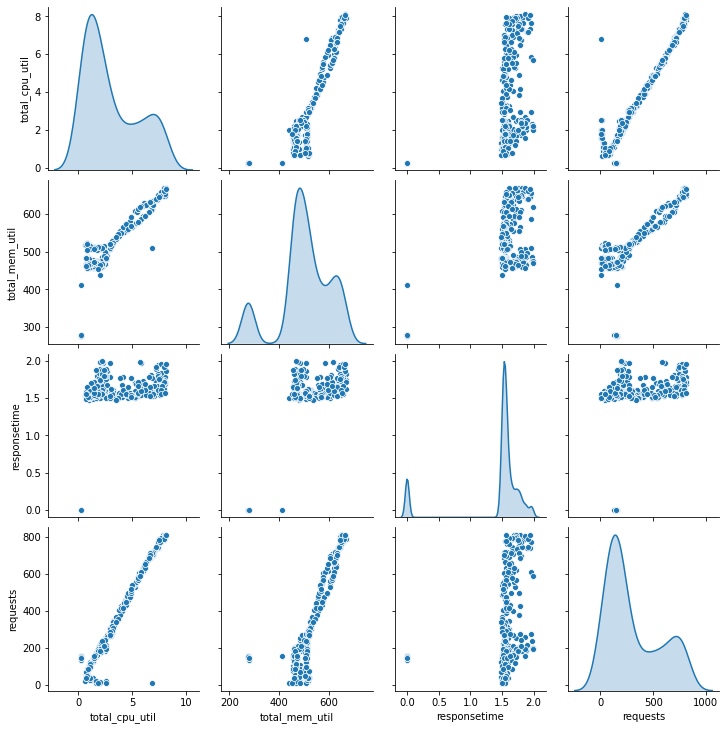

In [10]:
sns.pairplot(train_dataset[['total_cpu_util', 'total_mem_util', 'responsetime', 'requests']], diag_kind='kde')

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
total_cpu_util,325.0,3.024387,2.449380,0.261747,1.029120,2.108490,4.945493,8.102533
total_mem_util,325.0,506.194817,100.824692,274.987827,466.593178,507.326054,573.620429,669.589094
responsetime,325.0,1.440604,0.514268,0.000000,1.521409,1.554416,1.645840,1.993447
requests,325.0,307.286154,250.918402,7.000000,133.000000,194.000000,517.000000,810.000000


In [12]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

In [13]:
train_features.head()

,total_cpu_util,total_mem_util,responsetime,requests
1634,0.676295,484.059955,1.507232,39.0
2096,2.305247,485.513011,1.971115,237.0
374,2.448180,506.028442,1.590667,255.0
2084,1.750263,473.932800,1.794421,184.0
456,7.903767,669.120307,1.748552,787.0


In [14]:
train_labels = train_features.pop('requests')
val_labels = val_features.pop('requests')
test_labels = test_features.pop('requests')

In [15]:
normalizer = preprocessing.Normalization()

In [16]:
normalizer.adapt(np.array(train_features))

In [17]:
print(normalizer.mean.numpy())

[  3.024 506.195   1.441]


## Linear Regression

In [18]:
input = np.array(train_features[['total_cpu_util', 'total_mem_util', 'responsetime']])

input_normalizer = preprocessing.Normalization(input_shape=[3,])
input_normalizer.adapt(input)

In [19]:
model = tf.keras.Sequential([
    input_normalizer,
    layers.Dense(units=1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 11
Trainable params: 4
Non-trainable params: 7
_________________________________________________________________


In [20]:
model.predict(test_features)

array([[-4.812],
       [-4.839],
       [ 0.71 ],
       [ 0.676],
       [ 0.817],
       [ 0.676],
       [ 0.903],
       [ 0.913],
       [ 0.89 ],
       [ 0.92 ],
       [ 0.959],
       [ 0.828],
       [ 0.816],
       [ 0.88 ],
       [ 0.753],
       [ 0.768],
       [ 0.631],
       [ 0.643],
       [ 0.595],
       [ 0.634],
       [ 0.479],
       [ 0.504],
       [ 0.413],
       [ 0.36 ],
       [ 0.558],
       [ 0.207],
       [ 0.23 ],
       [ 0.157],
       [ 0.074],
       [ 0.128],
       [-0.217],
       [-0.22 ],
       [-0.051],
       [-0.152],
       [-0.262],
       [-0.252],
       [-0.399],
       [-0.48 ],
       [-0.485],
       [-0.547],
       [-0.601],
       [-0.646],
       [-0.787],
       [-0.721],
       [-0.871],
       [-0.882],
       [-0.98 ],
       [-0.856],
       [-1.006],
       [-1.083],
       [-1.242],
       [-1.218],
       [-1.24 ],
       [-1.124],
       [-1.403],
       [-1.395],
       [-1.587],
       [-1.654],
       [-1.645

In [21]:
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [22]:
%%time
history = model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.71 s, sys: 266 ms, total: 2.98 s
Wall time: 2.29 s


In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,236.992279,217.253571,95
96,236.210953,216.592834,96
97,235.458344,215.915573,97
98,234.681702,215.233444,98
99,233.952469,214.542267,99


In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 500])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

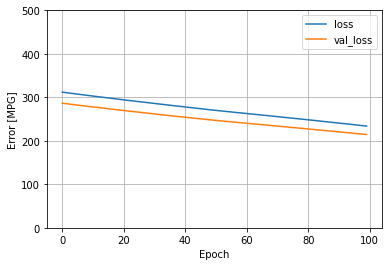

In [25]:
plot_loss(history)

In [26]:
test_results = {}

test_results['model'] = model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']],
    val_labels, verbose=0)

In [27]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [28]:
dnn_model = build_and_compile_model(input_normalizer)

In [29]:
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 3)                 7         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


In [30]:
%%time
history = dnn_model.fit(
    train_features[['total_cpu_util', 'total_mem_util', 'responsetime']], train_labels,
    validation_split=0.2,
    verbose=0, epochs=200)

CPU times: user 6.01 s, sys: 845 ms, total: 6.85 s
Wall time: 4.91 s


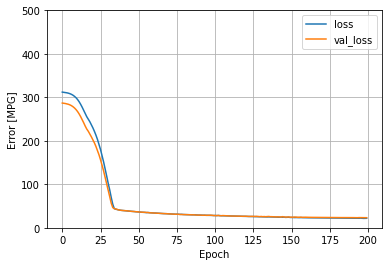

In [31]:
plot_loss(history)

In [32]:
test_results['dnn_model'] = dnn_model.evaluate(
    val_features[['total_cpu_util', 'total_mem_util', 'responsetime']], val_labels,
    verbose=0)

In [33]:
pd.DataFrame(test_results, index=['requests']).T

,requests
model,244.674835
dnn_model,13.778139


## Make Predictions

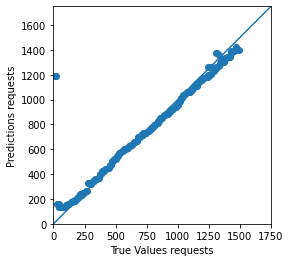

In [34]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values requests')
plt.ylabel('Predictions requests')
lims = [0, 1750]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [35]:
from sklearn.metrics import r2_score
R = r2_score(test_labels, test_predictions)
print ('R² :',R)

R² : 0.9116815065070397


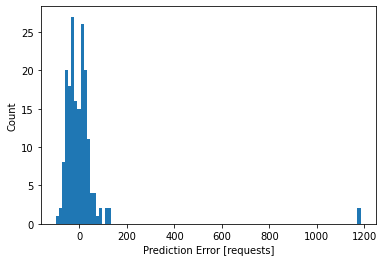

In [36]:
error = test_predictions - test_labels
plt.hist(error, bins=100)
plt.xlabel('Prediction Error [requests]')
_ = plt.ylabel('Count')